In [1]:
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
import sqlite3
%pylab inline

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Populating the interactive namespace from numpy and matplotlib


In [2]:
fName = "/home/bharat/Documents/code/sson_pred/data/20190103-22-53-substorms.csv"
# newFname = "../data/filtered-20190103-22-53-substorms.csv"
normMLTLim = [ -5, 5 ]
mlatLim = [ 55, 75 ]

In [3]:
smssDF = pandas.read_csv(fName, parse_dates=["Date_UTC"])
# rename the cols
smssDF.columns = [ "datetime", "mlat", "mlt" ]
smssDF['normMLT'] = [x-24 if x >= 12 else x\
                     for x in smssDF['mlt']]
smssDF.head()

,datetime,mlat,mlt,normMLT
0,1996-01-01 20:16:00,71.32,22.45,-1.55
1,1996-01-01 23:36:00,70.23,0.07,0.07
2,1996-01-02 00:25:00,69.36,22.92,-1.08
3,1996-01-02 14:12:00,70.06,23.20,-0.80
4,1996-01-02 16:09:00,65.81,0.62,0.62


In [4]:
filteredSMDF = smssDF[ ( smssDF["normMLT"] >= normMLTLim[0] ) &\
                     ( smssDF["normMLT"] <= normMLTLim[1] ) &\
                     ( smssDF["mlat"] >= mlatLim[0] ) &\
                     ( smssDF["mlat"] <= mlatLim[1] ) ]

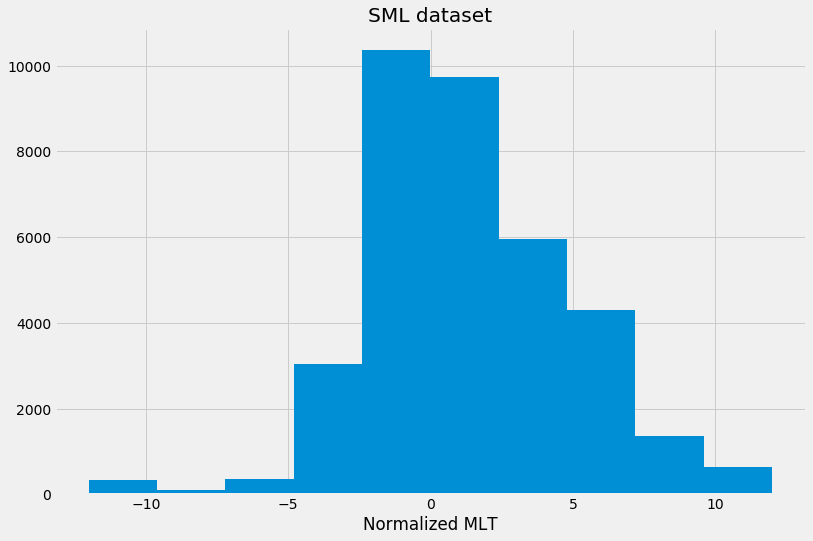

In [5]:
# bins = range(0,2000,20)#[0,10,20,40,60,120,240,2400]

plt.style.use("fivethirtyeight")
f = plt.figure(figsize=(12, 8))

ax1 = f.add_subplot(1,1,1)

hist = ax1.hist(smssDF['normMLT'].values)

# ax1.set_xlim(0,24)
ax1.set_title("SML dataset")
ax1.set_xlabel("Normalized MLT")


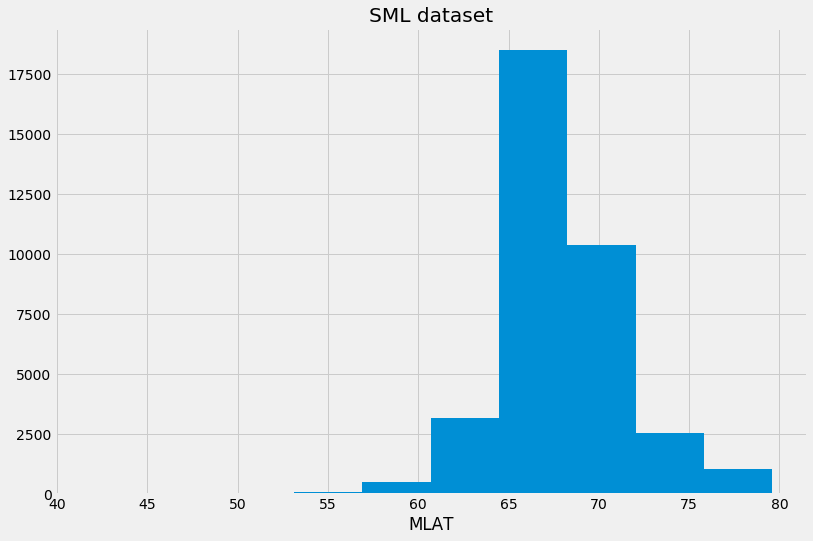

In [6]:
# bins = range(0,2000,20)#[0,10,20,40,60,120,240,2400]

plt.style.use("fivethirtyeight")
f = plt.figure(figsize=(12, 8))

ax1 = f.add_subplot(1,1,1)

hist = ax1.hist(smssDF['mlat'].values)

# ax1.set_xlim(0,24)
ax1.set_title("SML dataset")
ax1.set_xlabel("MLAT")


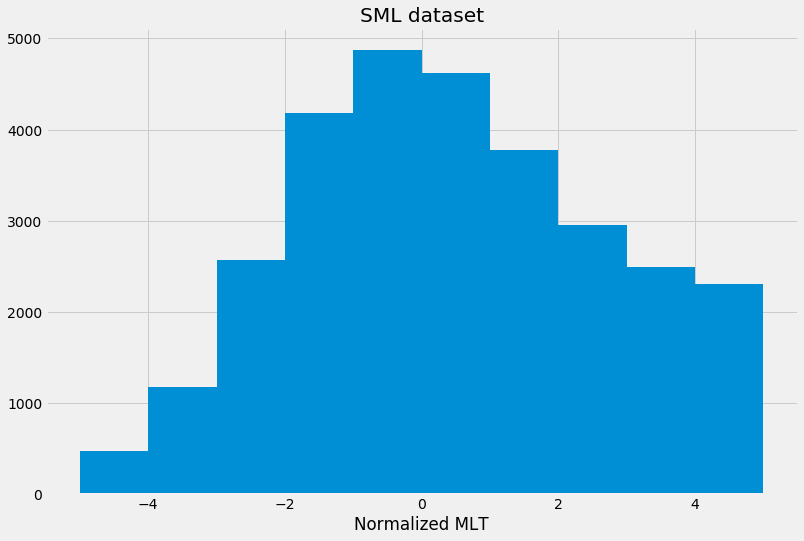

In [7]:
# bins = range(0,2000,20)#[0,10,20,40,60,120,240,2400]

plt.style.use("fivethirtyeight")
f = plt.figure(figsize=(12, 8))

ax1 = f.add_subplot(1,1,1)

hist = ax1.hist(filteredSMDF['normMLT'].values)

# ax1.set_xlim(0,24)
ax1.set_title("SML dataset")
ax1.set_xlabel("Normalized MLT")


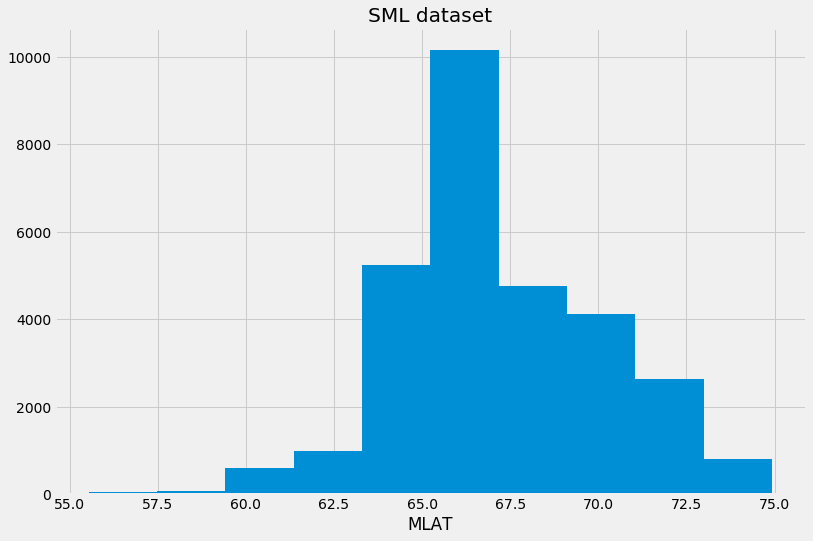

In [8]:
# bins = range(0,2000,20)#[0,10,20,40,60,120,240,2400]

plt.style.use("fivethirtyeight")
f = plt.figure(figsize=(12, 8))

ax1 = f.add_subplot(1,1,1)

hist = ax1.hist(filteredSMDF['mlat'].values)

# ax1.set_xlim(0,24)
ax1.set_title("SML dataset")
ax1.set_xlabel("MLAT")


In [9]:
start_date = filteredSMDF["datetime"].min() - datetime.timedelta(hours=2)
end_date = filteredSMDF["datetime"].max()
print start_date, end_date

1996-01-01 18:16:00 2017-12-31 21:09:00


In [10]:
omn_dbdir = "../data/sqlite3/"
omn_db_name = "smu_sml_sme.sqlite"
omn_table_name = "smusmlsme"

In [11]:
# read omni data
conn = sqlite3.connect(omn_dbdir + omn_db_name,
                       detect_types = sqlite3.PARSE_DECLTYPES)
# load data to a dataframe
command = "SELECT datetime, al, ae, au FROM {tb} WHERE datetime BETWEEN '{stm}' and '{etm}'"
command = command.format(tb=omn_table_name,\
                         stm=start_date, etm=end_date)
smlDF = pandas.read_sql(command, conn)
# drop nan's
smlDF.dropna(inplace=True)
smlDF.set_index(smlDF["datetime"], inplace=True)
smlDF.head()

,datetime,al,ae,au
datetime,,,,
1996-01-01 18:16:00,1996-01-01 18:16:00,-22,104,81
1996-01-01 18:17:00,1996-01-01 18:17:00,-22,103,81
1996-01-01 18:18:00,1996-01-01 18:18:00,-21,101,80
1996-01-01 18:19:00,1996-01-01 18:19:00,-23,103,79
1996-01-01 18:20:00,1996-01-01 18:20:00,-21,101,79


In [12]:
def get_sml_vars(row):
    """
    Get mean, median, std, min and max of sml 
    during various substorms over the next interval range.
    """
    delTimeList = [30,60]#[ 15, 30, 60, 120 ]
    for _dtl in delTimeList:
        _pd = row["datetime"] - datetime.timedelta(minutes=10)
        _cd = row["datetime"] + datetime.timedelta(minutes=1)
#         _cdtList = [ _cd + datetime.timedelta(minutes=_x) for\
#                         _x in range(_dtl) ]
        _ed = row["datetime"] + datetime.timedelta(minutes=_dtl)
        _resDF = smlDF[ _cd : _ed ]
        _baselineAl = smlDF[ _pd : _cd ]["al"].median()
        _baselineAe = smlDF[ _pd : _cd ]["ae"].median()
#         _resDF = smlDF[ smlDF["datetime"].isin(_cdtList) ]
        row["mean_al_" + str(_dtl)] = _resDF["al"].mean()
        row["median_al_" + str(_dtl)] = _resDF["al"].median()
        row["std_al_" + str(_dtl)] = _resDF["al"].std()
        row["min_al_" + str(_dtl)] = _resDF["al"].min()
        row["max_al_" + str(_dtl)] = _resDF["al"].max()
        row["mean_ae_" + str(_dtl)] = _resDF["ae"].mean()
        row["median_ae_" + str(_dtl)] = _resDF["ae"].median()
        row["std_ae_" + str(_dtl)] = _resDF["ae"].std()
        row["min_ae_" + str(_dtl)] = _resDF["ae"].min()
        row["max_ae_" + str(_dtl)] = _resDF["ae"].max()
        row["mean_au_" + str(_dtl)] = _resDF["au"].mean()
        row["median_au_" + str(_dtl)] = _resDF["au"].median()
        row["std_au_" + str(_dtl)] = _resDF["au"].std()
        row["min_au_" + str(_dtl)] = _resDF["au"].min()
        row["max_au_" + str(_dtl)] = _resDF["au"].max()
        row["al_dip_" + str(_dtl)] = _resDF["al"].min() - _baselineAl
        row["ae_dip_" + str(_dtl)] = _resDF["ae"].max() - _baselineAe
    return row

filteredSMDF = filteredSMDF.apply( get_sml_vars, axis=1 )

In [13]:
filteredSMDF.head()

,datetime,mlat,mlt,normMLT,mean_al_30,median_al_30,std_al_30,min_al_30,max_al_30,mean_ae_30,...,std_ae_60,min_ae_60,max_ae_60,mean_au_60,median_au_60,std_au_60,min_au_60,max_au_60,al_dip_60,ae_dip_60
0,1996-01-01 20:16:00,71.32,22.45,-1.55,-392.800000,-381.0,87.923713,-604.0,-244.0,505.966667,...,169.504159,165.0,841.0,86.683333,63.0,51.787863,51.0,240.0,-472.0,615.0
1,1996-01-01 23:36:00,70.23,0.07,0.07,-194.033333,-186.5,59.690861,-317.0,-109.0,267.133333,...,72.364213,122.0,390.0,74.450000,74.0,2.346472,70.0,80.0,-269.5,266.0
2,1996-01-02 00:25:00,69.36,22.92,-1.08,-231.466667,-229.0,55.030859,-348.0,-133.0,305.066667,...,70.116680,147.0,420.0,74.083333,74.0,1.915960,71.0,80.0,-276.0,270.5
3,1996-01-02 14:12:00,70.06,23.20,-0.80,-151.733333,-144.5,36.997608,-222.0,-80.0,221.733333,...,57.025445,94.0,341.0,58.966667,48.5,26.649620,30.0,166.0,-186.0,226.5
4,1996-01-02 16:09:00,65.81,0.62,0.62,-294.733333,-287.0,89.158879,-476.0,-169.0,376.033333,...,99.128250,170.0,570.0,74.566667,82.0,19.475640,32.0,101.0,-357.0,412.0


In [14]:
filteredSMDF.to_csv("../data/substorm-smul-dataset.csv")

In [15]:
# # save as csv file
# saveCols = [ "datetime", "mlat", "mlt" ]
# newColNames = [ "Date_UTC", "MLAT", "MLT" ]
# saveFltrDF = filteredSMDF[saveCols]
# saveFltrDF.columns = newColNames
# saveFltrDF.reset_index(drop=True).to_csv(newFname, index=False)

In [16]:
filteredSMDF.head()

,datetime,mlat,mlt,normMLT,mean_al_30,median_al_30,std_al_30,min_al_30,max_al_30,mean_ae_30,...,std_ae_60,min_ae_60,max_ae_60,mean_au_60,median_au_60,std_au_60,min_au_60,max_au_60,al_dip_60,ae_dip_60
0,1996-01-01 20:16:00,71.32,22.45,-1.55,-392.800000,-381.0,87.923713,-604.0,-244.0,505.966667,...,169.504159,165.0,841.0,86.683333,63.0,51.787863,51.0,240.0,-472.0,615.0
1,1996-01-01 23:36:00,70.23,0.07,0.07,-194.033333,-186.5,59.690861,-317.0,-109.0,267.133333,...,72.364213,122.0,390.0,74.450000,74.0,2.346472,70.0,80.0,-269.5,266.0
2,1996-01-02 00:25:00,69.36,22.92,-1.08,-231.466667,-229.0,55.030859,-348.0,-133.0,305.066667,...,70.116680,147.0,420.0,74.083333,74.0,1.915960,71.0,80.0,-276.0,270.5
3,1996-01-02 14:12:00,70.06,23.20,-0.80,-151.733333,-144.5,36.997608,-222.0,-80.0,221.733333,...,57.025445,94.0,341.0,58.966667,48.5,26.649620,30.0,166.0,-186.0,226.5
4,1996-01-02 16:09:00,65.81,0.62,0.62,-294.733333,-287.0,89.158879,-476.0,-169.0,376.033333,...,99.128250,170.0,570.0,74.566667,82.0,19.475640,32.0,101.0,-357.0,412.0


In [17]:
filteredSMDF2 = filteredSMDF.dropna()

{'boxes': [<matplotlib.lines.Line2D at 0x7f26ceb56210>],
 'caps': [<matplotlib.lines.Line2D at 0x7f26ce547450>,
 'fliers': [],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f26c8b42750>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f26ceb56cd0>,
  <matplotlib.lines.Line2D at 0x7f26ce547350>]}

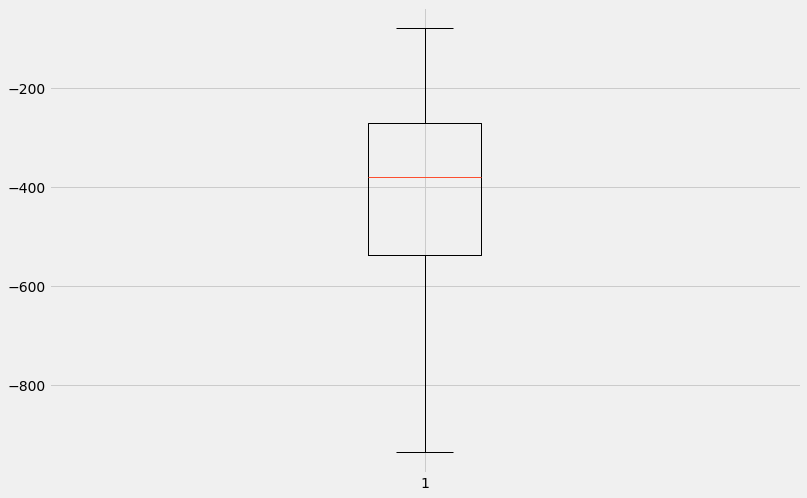

In [18]:
# bins = range(0,2000,20)#[0,10,20,40,60,120,240,2400]

plt.style.use("fivethirtyeight")
f = plt.figure(figsize=(12, 8))

ax1 = f.add_subplot(1,1,1)

ax1.boxplot( filteredSMDF2["mean_al_30"].values, showfliers=False )

In [22]:
print smssDF.shape
print filteredSMDF.shape
print filteredSMDF2.shape
alDipCutoff = -300
alCutoff = -300
alFilteredSMDF = filteredSMDF[ (filteredSMDF["min_al_60"] >= -3000) &\
                           (filteredSMDF["max_ae_60"] <= 3000) &\
                           (filteredSMDF["al_dip_60"] < 0) &\
                           (filteredSMDF["ae_dip_60"] > 0)]
print alFilteredSMDF.shape


(36238, 4)
(29421, 38)
(29420, 38)
(29086, 38)


In [25]:
# save as csv file
newFname = "../data/filtered-20190103-22-53-substorms.csv"
saveCols = [ "datetime", "mlat", "mlt" ]
newColNames = [ "Date_UTC", "MLAT", "MLT" ]
saveFltrDF = alFilteredSMDF[saveCols]
saveFltrDF.columns = newColNames
saveFltrDF.reset_index(drop=True).to_csv(newFname, index=False)

In [24]:
print newFname

../data/filtered-20190103-22-53-substorms.csv
